In [10]:
# Importing the required packages

from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Input
from keras.models import Model

# Loading the training and test dataset
(x_train,_),(x_test,_) = mnist.load_data()

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = np.reshape(x_train,(len(x_train),28,28,1))
x_test = np.reshape(x_test,(len(x_test),28,28,1))

# adding noise to the dataset
noise_factor = 0.5

# randomly adding noise to the data
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0,scale=1.0,size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0,scale=1.0,size=x_test.shape)

# clipping all values in the dataset that are above 1 or below 0 to either 1 or 0
x_train_noisy = np.clip(x_train_noisy,0,1)
x_test_noisy = np.clip(x_test_noisy,0,1)

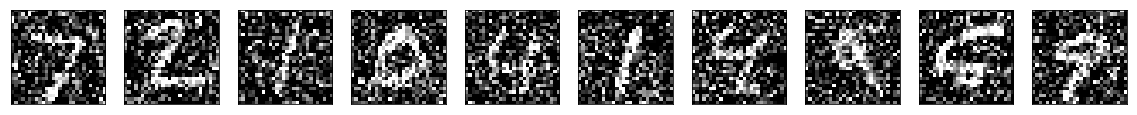

In [11]:
# Have a look at the dataset after adding noise to it
n = 10
plt.figure(figsize=(20,2))

for i in range(n):
    ax = plt.subplot(1,n,i+1)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [22]:
# Encoder Part
input_img = Input(shape=(28,28,1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)
# Decoder Part

decoder_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
decoder_upsamp1 = UpSampling2D((2, 2))
decoder_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')
decoder_upsamp2 = UpSampling2D((2, 2))
decoder_conv3 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')


x = decoder_conv1(encoded)
x = decoder_upsamp1(x)
x = decoder_conv2(x)
x = decoder_upsamp2(x)
decoder_output = decoder_conv3(x)

#Creating autoencoder model
autoencoder = Model(input_img, decoder_output)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [23]:
#Creating encoder model
encoder = Model(input_img, encoded)
encoder_imgs = encoder.predict(x_test_noisy)


decoder_input = Input(shape=(7,7,32,))
_x = decoder_conv1(decoder_input)
_x = decoder_upsamp1(_x)
_x = decoder_conv2(_x)
_x = decoder_upsamp2(_x)
_decoder_output = decoder_conv3(_x)

#Creating decoder model
decoder = Model(decoder_input, _decoder_output)


In [26]:
# Training the model on the dataset
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 213s 4ms/step - loss: 0.1571 - val_loss: 0.1227
Epoch 2/50
60000/60000 [==============================] - 207s 3ms/step - loss: 0.1196 - val_loss: 0.1158
Epoch 3/50
60000/60000 [==============================] - 220s 4ms/step - loss: 0.1128 - val_loss: 0.1099
Epoch 4/50
60000/60000 [==============================] - 211s 4ms/step - loss: 0.1090 - val_loss: 0.1066
Epoch 5/50
60000/60000 [==============================] - 207s 3ms/step - loss: 0.1066 - val_loss: 0.1032
Epoch 6/50
60000/60000 [==============================] - 207s 3ms/step - loss: 0.1046 - val_loss: 0.1031
Epoch 7/50
60000/60000 [==============================] - 205s 3ms/step - loss: 0.1035 - val_loss: 0.1029
Epoch 8/50
60000/60000 [==============================] - 210s 4ms/step - loss: 0.1024 - val_loss: 0.1012
Epoch 9/50
60000/60000 [==============================] - 207s 3ms/step - loss: 0.1018 - val_loss: 0.0

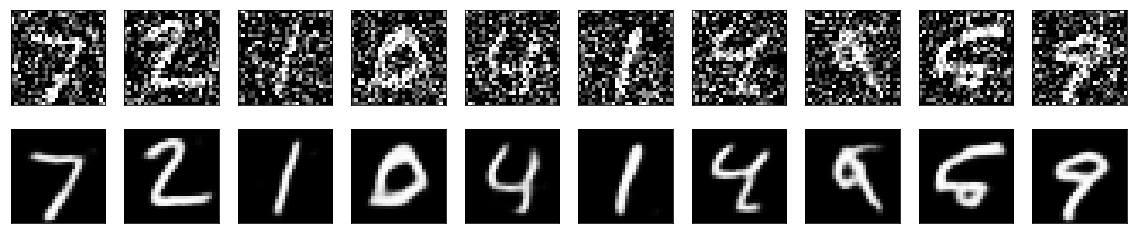

In [28]:
# Check the trained model performance on test set 
encoder_imgs = encoder.predict(x_test_noisy)
decoder_imgs = decoder.predict(encoder_imgs)

import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20,4))

for i in range(n):
    # Display original image
    ax = plt.subplot(2,n,i+1)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #Display decompressed image
    ax = plt.subplot(2,n,i+n+1)
    plt.imshow(decoder_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()